In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch
from highlight_text import ax_text, fig_text

from highlight_text import ax_text
from PIL import Image
from mplsoccer import add_image
import matplotlib.ticker as ticker
import urllib
from urllib.request import urlopen

from sklearn.cluster import KMeans
import matplotlib.patches as patches

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("D:\FData\Euro2024\Group_stage_all.csv")

In [3]:
df = pd.read_csv(r"D:\FData\LaLiga_2024_25\till_gw9.csv")

# For

C:\Users\h\AppData\Local\Temp\ipykernel_2016\657172648.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_pass['cluster'] = kmeans.predict(X)


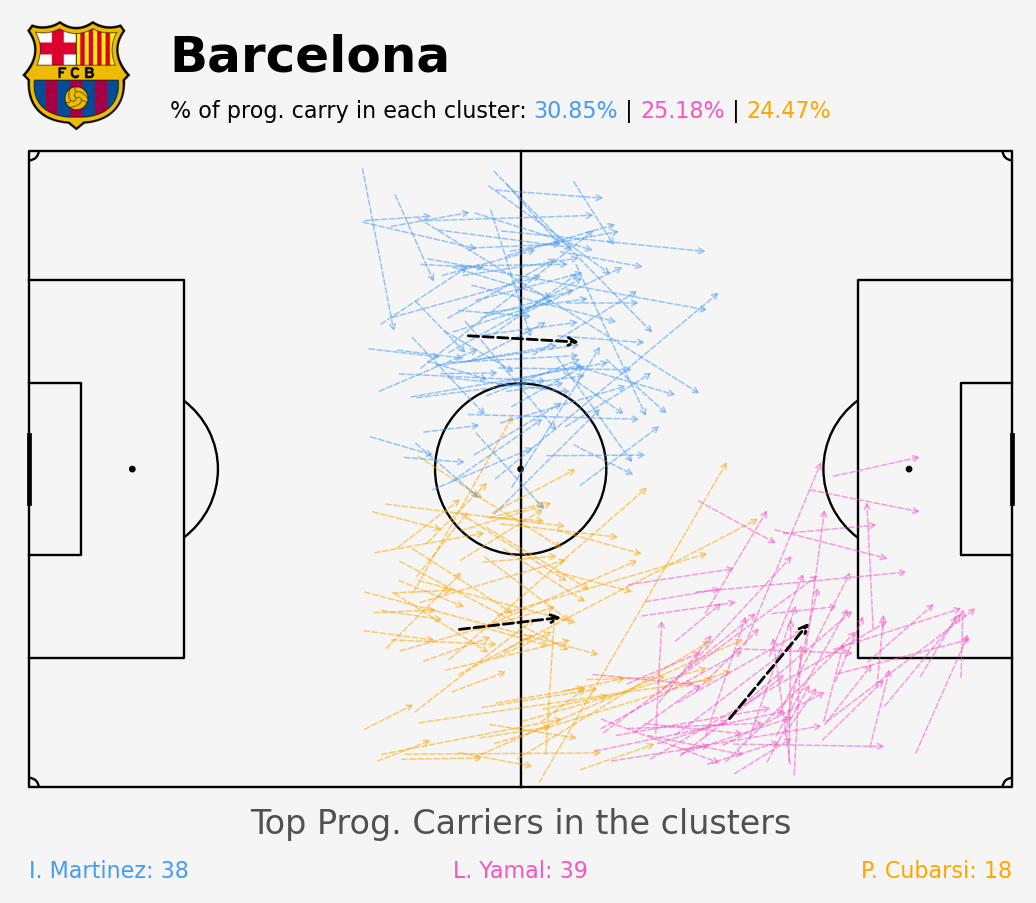

In [5]:
def plot_prog_carry(ax, team_name):
    df_team = df[(df['teamName']==team_name) & (df['type']=='Carry')]
    prog_pass = df_team[(df_team['prog_carry']>=7) & (df_team['x']>=35)]
    # Clustering
    X = np.array(prog_pass[['x','y','endX','endY']])
    kmeans = KMeans(n_clusters = 4, random_state = 100)
    kmeans.fit(X)
    prog_pass['cluster'] = kmeans.predict(X)
    cluster_counts = prog_pass['cluster'].value_counts()
    top_clusters = cluster_counts.nlargest(3).index
    # Create dataframes for the top clusters
    top_cluster_data_1 = prog_pass[prog_pass['cluster'] == top_clusters[0]]
    top_cluster_data_2 = prog_pass[prog_pass['cluster'] == top_clusters[1]]
    top_cluster_data_3 = prog_pass[prog_pass['cluster'] == top_clusters[2]]

    pitch = Pitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='k', linewidth=0.85, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5,105.5)

    for index, row in prog_pass.iterrows():
        if row['cluster'] == top_clusters[0]:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', linestyle='--', color='#479bf5', zorder=3, mutation_scale=5, alpha=0.55, linewidth=0.55)
            ax.add_patch(arrow)
        if row['cluster'] == top_clusters[1]:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', linestyle='--', color='#f754c4', zorder=2, mutation_scale=5, alpha=0.55, linewidth=0.55)
            ax.add_patch(arrow)
        if row['cluster'] == top_clusters[2]:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', linestyle='--', color='orange', zorder=1, mutation_scale=5, alpha=0.55, linewidth=0.55)
            ax.add_patch(arrow)

    x_med_1 = top_cluster_data_1['x'].median()
    x_med_2 = top_cluster_data_2['x'].median()
    x_med_3 = top_cluster_data_3['x'].median()
    y_med_1 = top_cluster_data_1['y'].median()
    y_med_2 = top_cluster_data_2['y'].median()
    y_med_3 = top_cluster_data_3['y'].median()
    
    arrow = patches.FancyArrowPatch((x_med_1, y_med_1), (top_cluster_data_1['endX'].median(), top_cluster_data_1['endY'].median()), arrowstyle='->', linestyle='--', color='k', zorder=3, mutation_scale=7, alpha=1)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((x_med_2, y_med_2), (top_cluster_data_2['endX'].median(), top_cluster_data_2['endY'].median()), arrowstyle='->', linestyle='--', color='k', zorder=2, mutation_scale=7, alpha=1)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((x_med_3, y_med_3), (top_cluster_data_3['endX'].median(), top_cluster_data_3['endY'].median()), arrowstyle='->', linestyle='--', color='k', zorder=1, mutation_scale=7, alpha=1)
    ax.add_patch(arrow)

    # Add percentage text
    colors = ['#479bf5', '#f754c4', 'orange']
    cluster_sizes = []
    for i, cluster in enumerate(top_clusters):
        cluster_data = prog_pass[prog_pass['cluster'] == cluster]
        cluster_sizes.append(len(cluster_data))
    total_passes = len(prog_pass)
    percentages = [round(size / total_passes * 100, 2) for size in cluster_sizes]
    percentage_text = ' | '.join([f"<{percentage}%>" for percentage in percentages])
    ax_text(15, 71, s=f'% of prog. carry in each cluster: {percentage_text}',
            highlight_textprops=[{"color": colors[i]} for i in range(3)], va="bottom", ha="left",
            fontsize=8, color="k", 
            #bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'),
    ax=ax)

    ax.text(15, 78, f'{team_name}', color='k', fontsize=18, fontweight='bold', ha='left', va='center')
    ax.text(52.5, -4, 'Top Prog. Carriers in the clusters', color='#505050', fontsize=12, ha='center', va='center')
    ax.text(0,-9, f"{top_cluster_data_1['shortName'].value_counts().index[0]}: {top_cluster_data_1['shortName'].value_counts().iloc[0]}", color='#479bf5', fontsize=8, ha='left', va='center')
    ax.text(52.5,-9, f"{top_cluster_data_2['shortName'].value_counts().index[0]}: {top_cluster_data_2['shortName'].value_counts().iloc[0]}", color='#f754c4', fontsize=8, ha='center', va='center')
    ax.text(105,-9, f"{top_cluster_data_3['shortName'].value_counts().index[0]}: {top_cluster_data_3['shortName'].value_counts().iloc[0]}", color='orange', fontsize=8, ha='right', va='center')


    # # Take data coordinates and transform them to normalized figure coordinates
    # DC_to_FC = ax.transData.transform
    # FC_to_NFC = fig.transFigure.inverted().transform
    # DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    # ax_coords = DC_to_NFC((-1,73))
    # ax_size = 0.1
    # image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    # fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/club_teams_logos/main/{team_name}.png'
    # fotmob_url = fotmob_url.replace(' ', '%20')
    # club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    # image_ax.imshow(club_icon)
    # image_ax.axis('off')
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(5, 76, image, height=12, ax=ax)
    
fig,ax = plt.subplots(facecolor='#f5f5f5', dpi=200)
plot_prog_carry(ax, 'Barcelona')

In [ ]:
%%time
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 4, figsize=(18, 20), facecolor='#f5f5f5', dpi=200)  # Adjusting figsize to better fit 20 subplots

team_names = ['Real Madrid', 'Barcelona', 'Girona', 'Atletico', 'Athletic Club', 'Real Sociedad', 'Real Betis', 'Villarreal', 
            'Valencia', 'Deportivo Alaves', 'Osasuna', 'Getafe', 'Celta Vigo', 'Sevilla', 'Mallorca', 'Las Palmas', 'Rayo Vallecano', 
            'Cadiz', 'Almeria', 'Granada']

for i in range(5):
    for j in range(4):
        plot_prog_carry(axs[i, j], team_names[i * 4 + j])

fig.text(0.23, 0.950, 'LaLiga Teams Progressive Carry Clusters', color='#ff4b44', fontweight='bold', fontsize=30, ha='left', va='center')
fig.text(0.23, 0.910, 'made by: @LaLigaStatsball @adnaaan433', color='#505050', fontsize=15, ha='left', va='center')
fig_text(
    x = 0.23, y = 0.930, 
    s = "Season 2023-24 | <1st>, <2nd> & <3rd> most common Clusters of progressive carries",
    highlight_textprops=[{"color":"#479bf5"}, {"color":"#f754c4"}, {"color":"orange"}],
    va = "center", ha = "left",
    fontsize = 15, color = "#505050")
fig.text(0.45, 0.09, 'Attacking Direction = Left to right', color='k', fontsize=8, ha='right', va='center')
fig.text(0.55, 0.09, 'Black Arrow = Median Position of carries in cluster', color='k', fontsize=8, ha='left', va='center')

image_url = 'https://raw.githubusercontent.com/adnaaan433/league_logos/main/LaLiga.png'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.13, bottom=0.9, width=0.07, height=0.07)

# plt.savefig("D:\FData\LaLiga\EventData_VIZ\Team\Prog_Pass_cluster_for.png")

# Against

C:\Users\h\AppData\Local\Temp\ipykernel_2016\3935500052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_pass['cluster'] = kmeans.predict(X)


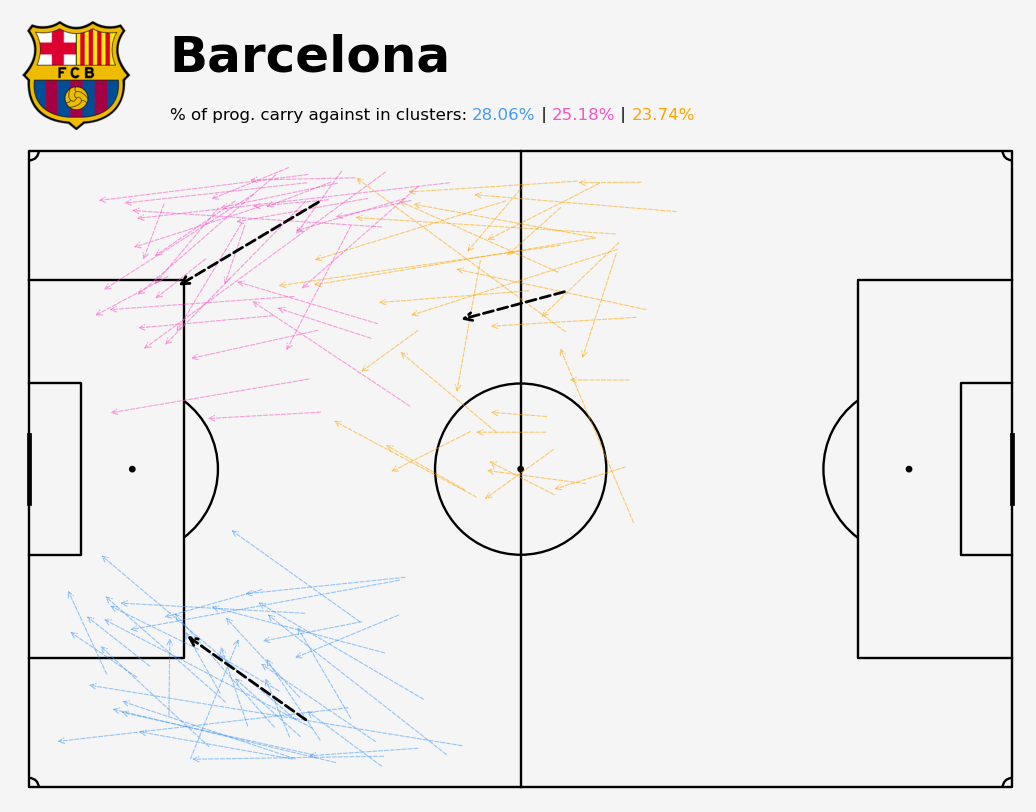

In [6]:
def plot_prog_carry_against(ax, team_name):
    df_team = df[(df['oppositionTeamName']==team_name) & (df['type']=='Carry')]
    prog_pass = df_team[(df_team['prog_carry']>=7) & (df_team['x']>=35)]
    # Clustering
    X = np.array(prog_pass[['x','y','endX','endY']])
    kmeans = KMeans(n_clusters = 4, random_state = 100)
    kmeans.fit(X)
    prog_pass['cluster'] = kmeans.predict(X)
    cluster_counts = prog_pass['cluster'].value_counts()
    top_clusters = cluster_counts.nlargest(3).index
    # Create dataframes for the top clusters
    top_cluster_data_1 = prog_pass[prog_pass['cluster'] == top_clusters[0]]
    top_cluster_data_2 = prog_pass[prog_pass['cluster'] == top_clusters[1]]
    top_cluster_data_3 = prog_pass[prog_pass['cluster'] == top_clusters[2]]

    pitch = Pitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='k', linewidth=0.85, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.invert_xaxis()
    ax.set_xlim(105.5,-0.5)
    ax.set_ylim(-0.5)

    for index, row in prog_pass.iterrows():
        if row['cluster'] == top_clusters[0]:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', linestyle='--', color='#479bf5', zorder=3, mutation_scale=5, alpha=0.55, linewidth=0.4)
            ax.add_patch(arrow)
        if row['cluster'] == top_clusters[1]:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', linestyle='--', color='#f754c4', zorder=2, mutation_scale=5, alpha=0.55, linewidth=0.4)
            ax.add_patch(arrow)
        if row['cluster'] == top_clusters[2]:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', linestyle='--', color='orange', zorder=1, mutation_scale=5, alpha=0.55, linewidth=0.4)
            ax.add_patch(arrow)

    x_med_1 = top_cluster_data_1['x'].median()
    x_med_2 = top_cluster_data_2['x'].median()
    x_med_3 = top_cluster_data_3['x'].median()
    y_med_1 = top_cluster_data_1['y'].median()
    y_med_2 = top_cluster_data_2['y'].median()
    y_med_3 = top_cluster_data_3['y'].median()
    
    arrow = patches.FancyArrowPatch((x_med_1, y_med_1), (top_cluster_data_1['endX'].median(), top_cluster_data_1['endY'].median()), arrowstyle='->', linestyle='--', color='k', zorder=3, mutation_scale=7, alpha=1)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((x_med_2, y_med_2), (top_cluster_data_2['endX'].median(), top_cluster_data_2['endY'].median()), arrowstyle='->', linestyle='--', color='k', zorder=2, mutation_scale=7, alpha=1)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((x_med_3, y_med_3), (top_cluster_data_3['endX'].median(), top_cluster_data_3['endY'].median()), arrowstyle='->', linestyle='--', color='k', zorder=1, mutation_scale=7, alpha=1)
    ax.add_patch(arrow)

    # Add percentage text
    colors = ['#479bf5', '#f754c4', 'orange']
    cluster_sizes = []
    for i, cluster in enumerate(top_clusters):
        cluster_data = prog_pass[prog_pass['cluster'] == cluster]
        cluster_sizes.append(len(cluster_data))
    total_passes = len(prog_pass)
    percentages = [round(size / total_passes * 100, 2) for size in cluster_sizes]
    percentage_text = ' | '.join([f"<{percentage}%>" for percentage in percentages])
    ax_text(90, 71, s=f'% of prog. carry against in clusters: {percentage_text}',
            highlight_textprops=[{"color": colors[i]} for i in range(3)], va="bottom", ha="left",
            fontsize=6, color="k", 
            #bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'),
    ax=ax)

    ax.text(90, 78, f'{team_name}', color='k', fontsize=18, fontweight='bold', ha='left', va='center')


    # # Take data coordinates and transform them to normalized figure coordinates
    # DC_to_FC = ax.transData.transform
    # FC_to_NFC = fig.transFigure.inverted().transform
    # DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    # ax_coords = DC_to_NFC((106,70))
    # ax_size = 0.02
    # image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    # fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/club_teams_logos/main/{team_name}.png'
    # fotmob_url = fotmob_url.replace(' ', '%20')
    # club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    # image_ax.imshow(club_icon)
    # image_ax.axis('off')
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(100, 76, image, height=12, ax=ax)

fig,ax = plt.subplots(facecolor='#f5f5f5', dpi=200)
plot_prog_carry_against(ax, 'Barcelona')

In [ ]:
%%time
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 4, figsize=(18, 18), facecolor='#f5f5f5', dpi=200)  # Adjusting figsize to better fit 20 subplots

team_names = ['Real Madrid', 'Barcelona', 'Girona', 'Atletico', 'Athletic Club', 'Real Sociedad', 'Real Betis', 'Villarreal', 
            'Valencia', 'Deportivo Alaves', 'Osasuna', 'Getafe', 'Celta Vigo', 'Sevilla', 'Mallorca', 'Las Palmas', 'Rayo Vallecano', 
            'Cadiz', 'Almeria', 'Granada']

for i in range(5):
    for j in range(4):
        plot_prog_carry_against(axs[i, j], team_names[i * 4 + j])

fig.text(0.23, 0.950, 'Progressive Carry Clusters Against LaLiga Teams', color='#ff4b44', fontweight='bold', fontsize=30, ha='left', va='center')
fig.text(0.23, 0.910, 'made by: @LaLigaStatsball @adnaaan433', color='#505050', fontsize=15, ha='left', va='center')
fig_text(
    x = 0.23, y = 0.930, 
    s = "Season 2023-24 | <1st>, <2nd> & <3rd> most common Clusters of progressive carries against",
    highlight_textprops=[{"color":"#479bf5"}, {"color":"#f754c4"}, {"color":"orange"}],
    va = "center", ha = "left",
    fontsize = 15, color = "#505050")
fig.text(0.45, 0.09, 'Attacking Direction = Left to right', color='k', fontsize=8, ha='right', va='center')
fig.text(0.55, 0.09, 'Black Arrow = Median Position of carries against in cluster', color='k', fontsize=8, ha='left', va='center')

image_url = 'https://raw.githubusercontent.com/adnaaan433/league_logos/main/LaLiga.png'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.13, bottom=0.9, width=0.07, height=0.07)

# plt.savefig("D:\FData\LaLiga\EventData_VIZ\Team\Prog_Pass_cluster_for.png")